based on https://github.com/apache/spark/blob/master/examples/src/main/python/kmeans.py

In [1]:
sc.version

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1675623994201_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'3.3.0-amzn-0'

In [2]:
import sys
from typing import List

import numpy as np
from pyspark.sql import SparkSession


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
np.random.seed(7)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Create Data

In [31]:
n_samples=1600
n_clusters=3
n_features =2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)
print(Xs.shape)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1600, 2)

In [33]:
#cluster_centers_np = np.random.randn(n_clusters, n_features)
#print(cluster_centers_np)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

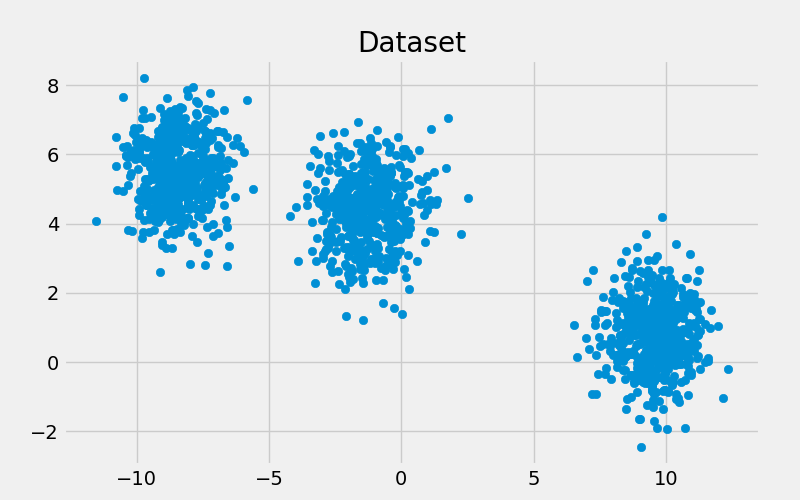

In [34]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

#C= cluster_centers_np
#plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')

%matplot plt

## Create an RDD from the data

In [35]:
data=sc.parallelize(list(Xs))
data.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[array([-7.51275775,  6.15915302]), array([8.56511441, 1.0490107 ]), array([10.41367584,  0.40109559]), array([-7.87769366,  5.54418566])]

In [36]:
# x_df=spark.createDataFrame(pd.DataFrame(Xs,columns=list(['x1','x2'])))
# x_df.show(5)
# x_df.rdd.take(2)
# def parseVector(row) -> np.ndarray:
#     return np.array([float(x) for x in row])
# data=x_df.rdd.map(parseVector).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
K = n_clusters
convergeDist = 0.1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Initial Cluster Centers**

In [38]:
kPoints = data.takeSample(False, K, 1) #(withReplacement, num, seed)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
kPoints

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[array([-2.08672967,  4.56917152]), array([-0.09504477,  4.79668217]), array([-0.54301727,  4.49955449])]

In [40]:
tempDist = 1.0


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Find the closest cluster centers to each point**

In [41]:
# The input is a point p and the list of the K cluster centers
def closestPoint(p: np.ndarray, centers: List[np.ndarray]) -> int:
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.sum((p - centers[i]) ** 2)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# map each point p to the index of the closest cluster center.
# index = closestPoint(p, kPoints)
# (index, (p,1)) These are key-value pairs

closest = data.map(lambda p: (closestPoint(p, kPoints), (p, 1)))
closest.take(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, (array([-7.51275775,  6.15915302]), 1)), (1, (array([8.56511441, 1.0490107 ]), 1)), (1, (array([10.41367584,  0.40109559]), 1)), (0, (array([-7.87769366,  5.54418566]), 1))]

In [43]:
# group the above object by keys, and then sum the values. The values have two coordinates a=p, and b=1
pointStats = closest.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# sum of points in each cluster, num of points in each cluster
pointStats.collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, (array([-5073.84099409,  4141.42653934]), 806)), (1, (array([5098.95846374,  913.29069683]), 628)), (2, (array([-123.30563445,  661.16989056]), 166))]

In [45]:
# calculate the new mean vectors
# (index, new vector)
newPoints = pointStats.map(lambda a: (a[0], a[1][0] / a[1][1])).collect()
newPoints

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, array([-6.29508808,  5.13824633])), (1, array([8.11936061, 1.45428455])), (2, array([-0.74280503,  3.98295115]))]

## Put Everything in a Loop 

In [46]:
while tempDist > convergeDist:
    closest = data.map(
        lambda p: (closestPoint(p, kPoints), (p, 1)))
    pointStats = closest.reduceByKey(
        lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(
        lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sum((kPoints[iK] - p) ** 2) for (iK, p) in newPoints)

    for (iK, p) in newPoints:
        kPoints[iK] = p
print("Final centers: " + str(kPoints))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Final centers: [array([-8.44680165,  5.50906448]), array([9.55109269, 0.78421667]), array([-1.27266133,  4.42037375])]

In [47]:
C=np.stack(kPoints)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

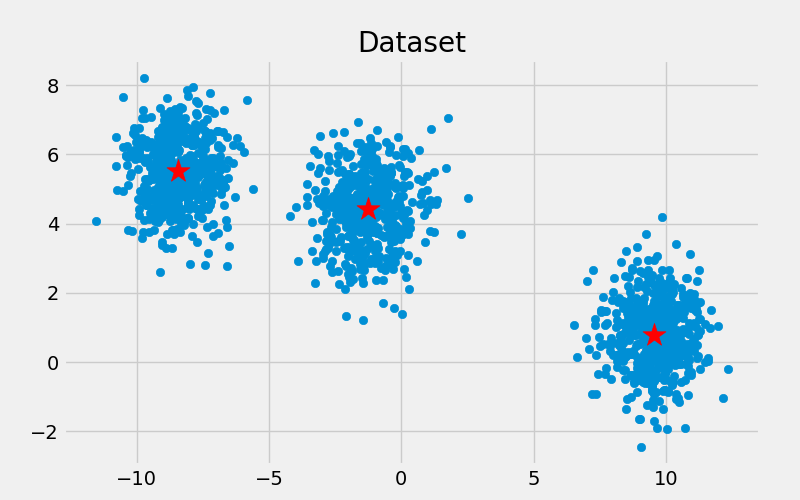

In [48]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

ax0 = fig.add_subplot(111)
ax0.scatter([point[0] for point in Xs], [point[1] for point in Xs])
ax0.set_title('Dataset')

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=300, c='r')

%matplot plt